In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from scipy.stats import chisquare
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [3]:
expression_sc = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv")

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Load and have a look at the pvalues that were computed abd saved previously

In [5]:
# Load the list of pvalues that I computed previously
pval_list_CD4_test = pickle.load( open("../CAR_data/pval_list_CD4_test", "rb"))
pval_list_CD8_test = pickle.load(open("../CAR_data/pval_list_CD8_test", "rb"))
pval_list_CD4_val = pickle.load( open("../CAR_data/pval_list_CD4_val", "rb"))
pval_list_CD8_val = pickle.load( open("../CAR_data/pval_list_CD8_val", "rb"))

In [6]:
print("pval CD4 test set: ", pval_list_CD4_test)
print("pval CD4 val set: ", pval_list_CD4_val)
print("pval CD8 test set: ", pval_list_CD8_test)
print("pval CD8 val set: ", pval_list_CD8_val)

pval CD4 test set:  {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.052, 4: 0.6, 5: 0.004, 6: 0.0, 7: 0.998, 8: 0.0, 9: 0.45}
pval CD4 val set:  {0: 0.8, 1: 0.776, 2: 0.638, 3: 0.668, 4: 0.032, 5: 0.802, 6: 0.146, 7: 0.92, 8: 0.916, 9: 0.476}
pval CD8 test set:  {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
pval CD8 val set:  {0: 0.016, 1: 0.714, 2: 0.986, 3: 0.37, 4: 0.522, 5: 0.938, 6: 0.286, 7: 0.258, 8: 0.218, 9: 0.154}


**For CD4: we sometime (in about 1/2 of the cases) manage to get a rather high p value on the test set, suggetsing that we can predict a distribution that's close enough to the true one.**

**For CD8 that never happens. (Can that be due to those NK T cells?? Idk)**

# Code

In [7]:


# For each different vector, get the associated class vector
def encode_cell_function(celltype, cell_function_list):
    """
        Transform a cell-type into an int.
        Args:
            - celltype: celltype to encore
            - cell_function_list: sorted list of possible cell functions.
            Its indexing will serve to encode the celltype.
    """
    return(cell_function_list.index(celltype))



def encode_domain(domain_name):
    """
         Compute one-hot encoding of CAR variant on 10 bits.
         Use alphabetical order of CAR domains: 41BB, CD28, CD40, CTLA4, IL15RA.
         The first 5 bits represent the first domain, the last 5 bits the second.
         When there is only one domain it is encoded on the first 5 bits.
         0 everywhere is TCR-
    """
    CAR_variant = domain_name.split("_")
    domains = ["h4-1BB", "hCD28", "hCD40", "hCTLA-4", "hIL15RA"] # The h is an artefact (of scanpy?)
    l = len(CAR_variant)
    encoding = [0,0,0,0,0,0,0,0,0,0]
    if l>1:
        index_1 = domains.index(CAR_variant[0])
        encoding[index_1] = 1
        if "NA" not in CAR_variant[1]:
            index_2 = domains.index(CAR_variant[1])
            encoding[index_2 + 5] = 1
    return(pd.Series(encoding))

def encode_domain_with_pos(domain_name):
    """
     Compute one-hot encoding of CAR variant on 20 bits.
     Use alphabetical order of CAR domains: 41BB, CD28, CD40, CTLA4, IL15RA.
     For the ith domain: 
         + the i*4th position represents whether this domain is present or not.
         + the i*4+1th position represents whether this domain is the only domain of the variant
         + the i*4+2 and i*4+3 position represent whther the domain is present in the 1st or 2nd position 
             in the case where there are 2 domains.
     0 everywhere is TCR-
    """
    CAR_variant = domain_name.split("_")
    domains = ["h4-1BB", "hCD28", "hCD40", "hCTLA-4", "hIL15RA"] # The h is an artefact (of scanpy?)
    l = len(CAR_variant)
    encoding = [0]*20
    if l>1:
        index_1 = domains.index(CAR_variant[0])
        encoding[index_1*4] = 1
        if "NA" not in CAR_variant[1]:
            index_2 = domains.index(CAR_variant[1])
            encoding[index_1*4+2] = 1 # domain 1 is present in 1st position 
            encoding[index_2*4] = 1
            encoding[index_2*4+3] = 1 # domain 2 is present in 2nd position
        else: # There is only one domain
            encoding[index_1*4+1] = 1 # domain 1 is present alone
    return(pd.Series(encoding))

In [8]:
def get_training_and_test_sets(TF_expression, training_list):
    """
        Split the dataset in a train and a test set, as well as a validation set.
        The train set will contain all cells with input domains contained in training_list except the validation set
        The validation set will contain a couple single cells with CAR variants present in the training set
        Args:
            - TF_expression: a dataset of single cell data relating CAR_Variant to cell_type
            (needs to ne single-cell since one CAR variant can lead to several celltypes and we need to
            learn the probability)
            - training_list: list of CAR_variants to use in the training set. By default, all non specified
            CAR variants will go into the test set
    """
    TF_training = pd.DataFrame()
    TF_test = pd.DataFrame()
    training = []
    test = []
    for i in range(len(TF_expression)):
        curr_row = pd.Series(TF_expression.loc[i])
        if curr_row["CAR_Variant"] in training_list:
            training.append(i)
        else:
            test.append(i)
    TF_training = TF_expression.iloc[training]
    TF_test = TF_expression.iloc[test]
    return(TF_training, TF_test)

def get_validation_set(training_set, proportion):
    rng = np.random.default_rng(2)
    validation_set = pd.DataFrame()
    # Get the validation set = 1/proportion of training set:
    for car in list(np.unique(training_set["CAR_Variant"])):
        CAR_training = training_set[training_set["CAR_Variant"]==car]
        if len(CAR_training)>2: # If I have at least 2 cell in the training set, so that I can use one for validation
            sample_size = int(np.floor(len(CAR_training)/proportion))
            indices = rng.choice(list(CAR_training.index), replace = False, size = sample_size)
            indices = list(indices)
            validation_set = pd.concat([validation_set, CAR_training.loc[indices]])
            training_set = training_set.drop(indices)
    return(training_set, validation_set)

In [9]:
# Create the 2 different encoding

encoding_simple = expression_sc["CAR_Variant"].apply(encode_domain)
encoding_with_pos = expression_sc["CAR_Variant"].apply(encode_domain_with_pos)

encoding_simple["CAR_Variant"] = expression_sc["CAR_Variant"]
encoding_simple["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function,
                                                                      cell_function_list = sorted(np.unique(expression_sc["cell_type"])))
encoding_simple["Type"] = expression_sc["Type"]
encoding_simple["cell_type"] = expression_sc["cell_type"]

encoding_with_pos["CAR_Variant"] = expression_sc["CAR_Variant"]
encoding_with_pos["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function,
                                                                cell_function_list = sorted(np.unique(expression_sc["cell_type"])))
encoding_with_pos["Type"] = expression_sc["Type"]
encoding_with_pos["cell_type"] = expression_sc["cell_type"]

In [10]:
# Define the "core" training domains that should always be present in the training set
training_list_core =  ["TCR-",
                 "h4-1BB_h4-1BB", 
                 "h4-1BB_NA", 
                 "hCD28_hCD28", 
                 "hCD28_NA",
                 "hCD40_hCD40", 
                 "hCD40_NA", 
                 "hCTLA-4_hCTLA-4",
                 "hCTLA-4_NA",
                 "hIL15RA_hIL15RA",
                 "hIL15RA_NA"
                ]

other_domains = list(np.unique(expression_sc["CAR_Variant"]))
for i,c in enumerate (training_list_core):
    other_domains.remove(c)

In [11]:
def compare_proba_to_freq(test_CD4, pred_proba_CD4, test_CD8,  pred_proba_CD8, celltype_names):
    """
     Args:
            - test_CD4: pd.DataFrame of test set for CD4 cells
            - predictions_CD4: pd.DataFrame of class prediction on CD4 test set
            - test_CD8: pd.DataFrame of test set for CD4 cells
            - predictions_CD8: pd.DataFrame of class prediction on CD4 test set    
    Returns:
            - proba_df: pd.DataFrame which contains, for each (CAR Variant, Type) pair in the test set,
                the probabilities of each possible cell_type for this couple
    
    """
    #### Compare predicted probabilities to observed frequencies ###
    results_df = pd.DataFrame()
    car_CD4 = list(np.unique(pred_proba_CD4["CAR_Variant"]))
    car_CD8= list(np.unique(pred_proba_CD8["CAR_Variant"]))
    car_list = list(np.unique(car_CD4 + car_CD8))
    for car in car_list:
        for i in range(8):
            celltype = celltype_names[i]
            if i <4:
                CD_type = "CD4"
                res = pred_proba_CD4
                # res[res["CAR Variant"]] contains the probability of having each CD4 celltype
                # for this CAR variant
                if len(res[res["CAR_Variant"]== car][i])==0:
                    proba = 0
                else:
                    proba = float(res[res["CAR_Variant"]== car][i])
                true = test_CD4
            else:
                CD_type = "CD8"
                res = pred_proba_CD8
                if len(res[res["CAR_Variant"]== car][i-4])==0:
                    proba = 0 
                else:
                    proba = float(res[res["CAR_Variant"]== car][i-4])
                
                true = test_CD8
                
            # Observed frequency
            df_CAR = true[true["CAR_Variant"] == car]
            if len(df_CAR)==0: # hCTLA-4_h4-1BB only has CD4 cells (4 of them)
                # This adds a spurious (0,0) point but it should not influence the results much
                freq = 0
            else:
                freq = len(df_CAR[df_CAR["cell_type"]==celltype])/len(df_CAR)
            results_df = results_df.append(pd.Series([car, CD_type, celltype, proba, freq]), ignore_index=True)

    results_df.columns= ["CAR Variant", "Type", "Cell type", "Predicted probability", "True frequency"]
    return(results_df)

In [12]:
def prepare_train_test_and_val_sets(df, training_list, encoding, proportion, plot=False):
    if encoding == "simple":
        df = encoding_simple
    else:
        df = encoding_with_pos
    
    train, test = get_training_and_test_sets(df, training_list)
    
    train_CD4 = train[train["Type"] =="CD4"]
    test_CD4 = test[test["Type"] =="CD4"]
    train_CD4, validation_CD4 = get_validation_set(train_CD4, proportion)
    
    train_CD8 = train[train["Type"] =="CD8"]
    test_CD8 = test[test["Type"] =="CD8"]
    train_CD8, validation_CD8 = get_validation_set(train_CD8, proportion)

    if plot:
        # Plot the comparison of the frequencies between training set and validation set
         # For debugging purposes, compare frequencies in the training and validation set
        freq_CD4 = pd.DataFrame()
        for car in sorted(np.unique(train_CD4["CAR_Variant"])):
            for celltype in sorted(np.unique(df["cell_type"]))[0:4]:
                train_CAR_CD4 = train_CD4[train_CD4["CAR_Variant"] == car]
                freq_train_CD4 = len(train_CAR_CD4[train_CAR_CD4["cell_type"]==celltype])/(len(train_CAR_CD4)+0.0001)
                val_CAR_CD4 = validation_CD4[validation_CD4["CAR_Variant"] == car]
                freq_val_CD4 = len(val_CAR_CD4[val_CAR_CD4["cell_type"]==celltype])/(len(val_CAR_CD4)+0.0001)
                freq_CD4 = freq_CD4.append(pd.Series([car, celltype, freq_train_CD4, freq_val_CD4]), ignore_index=True)
        freq_CD4.columns = ["CAR", "celltype", "Train freq", "Val freq"]
        sns.relplot(data = freq_CD4, x = "Train freq", y = "Val freq")

        freq_CD8= pd.DataFrame()
        for car in sorted(np.unique(train_CD8["CAR_Variant"])):
            for celltype in sorted(np.unique(df["cell_type"]))[4:8]:
                train_CAR_CD8 = train_CD8[train_CD8["CAR_Variant"] == car]
                freq_train_CD8 = len(train_CAR_CD8[train_CAR_CD8["cell_type"]==celltype])/(len(train_CAR_CD8)+0.0001)
                val_CAR_CD8 = validation_CD8[validation_CD8["CAR_Variant"] == car]
                freq_val_CD8 = len(val_CAR_CD8[val_CAR_CD8["cell_type"]==celltype])/(len(val_CAR_CD8)+0.0001)
                freq_CD8 = freq_CD8.append(pd.Series([car, celltype, freq_train_CD8, freq_val_CD8]), ignore_index=True)
        freq_CD8.columns = ["CAR", "celltype", "Train freq", "Val freq"]
        sns.relplot(data = freq_CD8, x = "Train freq", y = "Val freq")

    return(train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8)



In [13]:
def get_predicted_class(test_CD4, predictions_CD4,test_CD8, predictions_CD8):
    """
        Args:
            - test_CD4: pd.DataFrame of test set for CD4 cells
            - predictions_CD4: pd.DataFrame of class prediction on CD4 test set
            - test_CD8: pd.DataFrame of test set for CD4 cells
            - predictions_CD8: pd.DataFrame of class prediction on CD4 test set
        Returns:
            - predictions: pd.DataFrame containing for each (CAR Variant, Type) couple in the test set,
                the value of the predicted class for this couple, and the true majority class
    
    """
    predictions = pd.DataFrame()
    car_CD4 = list(np.unique(predictions_CD4["CAR_Variant"]))
    car_CD8= list(np.unique(predictions_CD8["CAR_Variant"]))
    car_list = list(np.unique(car_CD4 + car_CD8))
    for car in car_list:
        #print(car)
        #print(car in car_CD4)
        #print(car in car_CD8)
        if car in car_CD4:
            # All cells with the same CAR are predicted the same celltype
            predicted_class_CD4 = float(predictions_CD4[predictions_CD4["CAR_Variant"]==car][0])
            # Value counts order by descending order
            majority_class_CD4 = test_CD4[test_CD4["CAR_Variant"]==car]["function_encoded"].value_counts().index[0]

            predictions = predictions.append(pd.Series([car, "CD4", predicted_class_CD4, majority_class_CD4]), ignore_index=True)

        if car in car_CD8:
            predicted_class_CD8 = float(predictions_CD8[predictions_CD8["CAR_Variant"]==car][0])
            majority_class_CD8 = test_CD8[test_CD8["CAR_Variant"]==car]["function_encoded"].value_counts().index[0]
            
            predictions = predictions.append(pd.Series([car, "CD8", predicted_class_CD8, majority_class_CD8]), ignore_index=True)
    predictions.columns = ["CAR Variant", "Type", "Predicted class", "Majority class"]
    return(predictions)

In [14]:
def fit_and_predict(predictor_cols, estimator, training_set, testing_set, fit = False):
    """
        Args:
            - predictor_cols: list of the column names describing the columns to use as predictors
            - estimator: estimator to train
            - training_set: set on which to train the estimator
            - testing_set: set on which to test the estimatpor
            - refit: whether to fit the stimator
        Returns:
            - y_pred: the matrix of predicted classes for each input CAR
            - predicted_proba: the matrix of predicted probabilities for each input CAR
    """
    if fit:
        # Fit the estimator
        estimator.fit(X = training_set[predictor_cols],
                   y = training_set["function_encoded"])
    # We don't predict on single cell but per CAR Variant
    # This dataframe contains 5 rows, each of whhich contains the bitwise encoding of one of the CAR Variants in the test set
    predictor_vector = testing_set[predictor_cols + ["CAR_Variant"]].groupby(predictor_cols + ["CAR_Variant"]).mean().reset_index()
    # We predict the classes
    y_pred = pd.DataFrame(estimator.predict(X = predictor_vector.drop("CAR_Variant", axis = 1)))
    y_pred["CAR_Variant"]=predictor_vector["CAR_Variant"]
    # We predict the class probabilities
    predicted_proba= pd.DataFrame(
        estimator.predict_proba(X = predictor_vector.drop("CAR_Variant", axis = 1))
    )
    predicted_proba["CAR_Variant"] = predictor_vector["CAR_Variant"]
    return(y_pred, predicted_proba)

In [15]:
def train_and_report_logistic_regression(df, training_list, encoding, proportion):
    """
        This uses the 5-folds cross-validated models from Classification_clean.ipynb, which maximise accuracy.
        For CD4, according to the GridSearchCV I would need C=1, multi_class='multinomial', penalty='l1', random_state=2,
                   solver='saga'
        For CD8, according to the GridSearchCV I would need C=1, multi_class='multinomial', random_state=2 (and the default l2 regularisation)
    """
    train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8  = prepare_train_test_and_val_sets(df, training_list, encoding, proportion)
    celltype_names = list(np.unique(df["cell_type"]))
    
    if encoding == "simple":
        predictor_cols = [i for i in range(10)]
    else:
        predictor_cols = [i for i in range(20)]
    
    ############ DO THE TRAINING AND FITTING ON CD4 #############################

    rf_CD4 = LogisticRegression(C=1, multi_class='multinomial',random_state=2,
                   solver='saga')
    pred_CD4, proba_CD4 = fit_and_predict(estimator=rf_CD4,
                                           testing_set=test_CD4,
                                           training_set=train_CD4,
                                           predictor_cols = predictor_cols,
                                           fit = True)
    
    
    ########### THEN DO THE SAME ON CD8 ########################
    rf_CD8 = LogisticRegression(C=1, multi_class='multinomial', random_state=2)
    
    pred_CD8, proba_CD8 = fit_and_predict(estimator=rf_CD8,
                                           testing_set=test_CD8,
                                           training_set=train_CD8,
                                           predictor_cols = predictor_cols,
                                         fit = True)
    
    ##########################################
        
    ## Results
    results_df = compare_proba_to_freq(test_CD4=test_CD4,
                                       pred_proba_CD4=proba_CD4,
                                       test_CD8=test_CD8,
                                       pred_proba_CD8=proba_CD8,
                                       celltype_names=celltype_names)
    
    ### See if the predicted class is the majority class ###
    predictions = get_predicted_class(test_CD4=test_CD4,
                                      predictions_CD4= pred_CD4,
                                      test_CD8=test_CD8,
                                      predictions_CD8 = pred_CD8)
    
    ## Then get the results and probabilities for the validation set
    pred_CD4_val, proba_CD4_val = fit_and_predict(estimator=rf_CD4,
                                           testing_set=validation_CD4,
                                           training_set=train_CD4,
                                           predictor_cols = predictor_cols,
                                                 fit = False)
    
    pred_CD8_val, proba_CD8_val = fit_and_predict(estimator=rf_CD8,
                                           testing_set=validation_CD8,
                                           training_set=train_CD8,
                                           predictor_cols = predictor_cols,
                                                 fit = False)
    val_df = pd.concat([validation_CD4, validation_CD8], ignore_index=True)
    results_val = compare_proba_to_freq(test_CD4=validation_CD4,
                                       pred_proba_CD4=proba_CD4_val,
                                       test_CD8=validation_CD8,
                                       pred_proba_CD8=proba_CD8_val,
                                       celltype_names=celltype_names)
   
    return(results_df, predictions, results_val )
            

In [16]:
 # Choose domains
rng = np.random.default_rng(2)

indices = list(rng.choice(len(other_domains), 5, replace = False))
print(indices)
test_list = [other_domains[i] for i in indices]
training_list = training_list_core + [c for c in other_domains if c not in test_list]

res_1, predictions, results_val = train_and_report_logistic_regression(expression_sc, training_list, "simple", 10)

[5, 1, 13, 4, 8]


In [16]:
predictions

,CAR Variant,Type,Predicted class,Majority class
0,h4-1BB_hCD40,CD4,1.0,0
1,h4-1BB_hCD40,CD8,4.0,4
2,hCD28_h4-1BB,CD4,3.0,3
3,hCD28_h4-1BB,CD8,4.0,5
4,hCD28_hCD40,CD4,3.0,3
5,hCD28_hCD40,CD8,5.0,4
6,hCD40_h4-1BB,CD4,3.0,3
7,hCD40_h4-1BB,CD8,4.0,4
8,hCTLA-4_hCD28,CD4,1.0,1
9,hCTLA-4_hCD28,CD8,4.0,4


In [17]:
results_val

,CAR Variant,Type,Cell type,Predicted probability,True frequency
0,TCR-,CD4,CD4 HLAhigh,0.468172,0.400000
1,TCR-,CD4,CD4 Memory,0.465397,0.550000
2,TCR-,CD4,CD4 Th2/Activated,0.000941,0.000000
3,TCR-,CD4,CD4 activated,0.065491,0.050000
4,TCR-,CD8,CD8 Cytox/Memory,0.270816,0.133333
...,...,...,...,...,...
195,hIL15RA_hIL15RA,CD4,CD4 activated,0.225859,0.173913
196,hIL15RA_hIL15RA,CD8,CD8 Cytox/Memory,0.305357,0.250000
197,hIL15RA_hIL15RA,CD8,CD8 Effector A,0.344153,0.250000
198,hIL15RA_hIL15RA,CD8,CD8 Effector HLAhigh,0.321764,0.500000


In [18]:
res_1[res_1["Type"] == "CD8"]

,CAR Variant,Type,Cell type,Predicted probability,True frequency
4,h4-1BB_hCD40,CD8,CD8 Cytox/Memory,0.492245,0.729412
5,h4-1BB_hCD40,CD8,CD8 Effector A,0.341711,0.082353
6,h4-1BB_hCD40,CD8,CD8 Effector HLAhigh,0.156336,0.152941
7,h4-1BB_hCD40,CD8,NK T cell,0.009708,0.035294
12,hCD28_h4-1BB,CD8,CD8 Cytox/Memory,0.627630,0.375000
13,hCD28_h4-1BB,CD8,CD8 Effector A,0.332037,0.375000
14,hCD28_h4-1BB,CD8,CD8 Effector HLAhigh,0.035166,0.250000
15,hCD28_h4-1BB,CD8,NK T cell,0.005167,0.000000
20,hCD28_hCD40,CD8,CD8 Cytox/Memory,0.232550,0.692308
21,hCD28_hCD40,CD8,CD8 Effector A,0.741448,0.153846


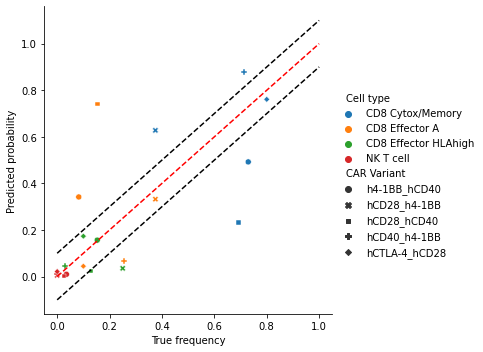

In [19]:

ident = np.linspace(0,1,100)
sns.relplot(x= "True frequency",
            y = "Predicted probability",
            style= "CAR Variant",
            hue="Cell type",
            data = res_1[res_1["Type"]=="CD8"])
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

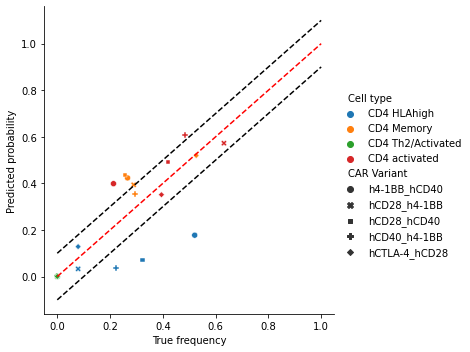

In [20]:
ident = np.linspace(0,1,100)
sns.relplot(x= "True frequency",
            y = "Predicted probability",
            style= "CAR Variant",
            hue="Cell type",
            data = res_1[res_1["Type"]=="CD4"])
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [17]:
def compute_likelihood(domain, CD_type, prediction_results_df, true_data_df, epsilon = 1e-6):
    # The likelihood is the product for each datapoint of the probability of having this celltype under
    # the predicted probability distribution
    """
        Args:
            - domain: the domain for which to compute the log-likelihood (the log-likelihood for all domains
                will later be summed in compute_likelihood_test_set)
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood
            - epsilon: penalty to use when the true celltype has a 0 predicted probability
            
    """

    pred = prediction_results_df[prediction_results_df["CAR Variant"]==domain]
    true = true_data_df[true_data_df["CAR_Variant"]==domain]
    
    LL = 0
    N = 0
    for celltype in list(true[true["Type"]==CD_type]["cell_type"]): # For each observed cell type
        p = float(pred[pred["Cell type"]==celltype]["Predicted probability"])
        if p==0:
            LL += np.log(epsilon) # Cannot take log of 0, hence use epsilon <<1
        else:
            LL += np.log(p)
        N+=1
    
    return(LL, N)

def compute_likelihood_test_set(CD_type, predictions_results_df, true_data_df, epsilon = 1e-6):
    """
        Args:
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood
            - epsilon: penalty to use when the true celltype has a 0 predicted probability
            
    """
    LL = 0
    N = 0
    predictions_results_df = predictions_results_df[predictions_results_df["Type"] == CD_type]
    for car in list(np.unique(true_data_df["CAR_Variant"])): # For the CARs that are in the test set
        
        LL_curr, N_curr = compute_likelihood(car, CD_type, predictions_results_df, true_data_df, epsilon)
        LL += LL_curr
        N+= N_curr
    return(LL) # Divide the loglikelihood by the number of points

In [18]:
def compute_pval_likelihood(CD_type, prediction_results_df, true_data_df, random_generator):
    """
        Args:
            - CD_type: CD4 or CD8, needs to be specified as we have a different model for each
            - prediction_results_df: dataframe containing predicted celltype probabilities for each CAR
            - true_data_df: dataframe containing the true celltypes of the cells for which
                we want to compute the likelihood. It is used here in order to determine and reproduce
                the repartition of the dataset in between different CAR variants.
            
    """
    LL = 0
    if CD_type == "CD4":
        types = sorted(np.unique(prediction_results_df["Cell type"]))[0:4]
    else: # CD8
        types = sorted(np.unique(prediction_results_df["Cell type"]))[4:8]
        
    true_data_df = true_data_df[true_data_df["Type"] == CD_type] # Only look at one CD type
    LL = 0
    batch_size = 0
    for car in true_data_df["CAR_Variant"]: 
        # For each cell that are in the observed sample I draw a cell with the same CAR 
        # (to have same CAR and CD-type distribution in my simulated batch than in my true observed sample)
        CAR_df = prediction_results_df[prediction_results_df["CAR Variant"] == car]
        # Get the probability for each cell type for the given CAR variant and CD type
        proba_vect = list(CAR_df[CAR_df["Cell type"].isin(types)]["Predicted probability"])
        
        draw = random_generator.choice(a  = [0,1,2,3], size = 1, p = proba_vect)[0]
        batch_size+=1
        
        # Compute the log likelihood of the batch
        LL += np.log(proba_vect[draw])
    #LL = LL/batch_size # Divide the loglikelihood by the number of points
    return(LL)

def compute_pval(CD_type, num_iter, prediction_results_df, true_data_df, epsilon=1e-6):
    rng = np.random.default_rng(2) # Reproducibility
    observed_LL = compute_likelihood_test_set(
        CD_type=CD_type,
        predictions_results_df = prediction_results_df,
        true_data_df = true_data_df,
        epsilon = epsilon)
    inferior = 0
    for i in range(num_iter):
        MC_LL = compute_pval_likelihood(CD_type = CD_type, true_data_df=true_data_df, prediction_results_df=prediction_results_df, random_generator = rng)
        if MC_LL<observed_LL:
            inferior+=1
    pval = inferior/num_iter
    return(pval)

In [19]:
# Now try with different test sets:

rng = np.random.default_rng(3)

res_list = []
pred_list = []
pval_list_CD4_test = {}
pval_list_CD8_test = {}
pval_list_CD4_val = {}
pval_list_CD8_val = {}
for i in tqdm(range(10), desc = "Test set loop"):
    indices = list(rng.choice(len(other_domains), 5, replace = False))
    test_list = [other_domains[i] for i in indices]
    training_list = training_list_core + [c for c in other_domains if c not in test_list]
    
    res,predictions, res_val= train_and_report_logistic_regression(expression_sc, training_list, "with_pos", 10)
    res_list.append(res)
    pred_list.append(predictions)
    train, test, train_CD4, test_CD4, validation_CD4, train_CD8, test_CD8, validation_CD8  = prepare_train_test_and_val_sets(
    expression_sc, training_list, "with_pos", 10)
    
#     ident = np.linspace(0,1,100)
#     sns.relplot(x= "True frequency",
#                 y = "Predicted probability",
#                 style= "CAR Variant",
#                 hue="Cell type",
#                 data = res[res["Type"]=="CD8"])
#     plt.plot(ident, ident, "--r")
#     plt.plot(ident, ident-0.1, "--k")
#     plt.plot(ident, ident+0.1, "--k")
#     plt.show()
    
#     sns.relplot(x= "True frequency",
#                 y = "Predicted probability",
#                 style= "CAR Variant",
#                 hue="Cell type",
#                 data = res[res["Type"]=="CD4"])
#     plt.plot(ident, ident, "--r")
#     plt.plot(ident, ident-0.1, "--k")
#     plt.plot(ident, ident+0.1, "--k")
#     plt.show()

    
    pval_list_CD4_test[i] = compute_pval(num_iter = 500, CD_type="CD4",
             prediction_results_df = res,
             true_data_df = test_CD4, epsilon = 1e-6)
    pval_list_CD8_test[i] = compute_pval(num_iter = 500, CD_type="CD8",
             prediction_results_df = res,
             true_data_df = test_CD8, epsilon = 1e-6)
    pval_list_CD4_val[i] =  compute_pval(num_iter = 500, CD_type="CD4",
             prediction_results_df = res_val,
             true_data_df = validation_CD4, epsilon = 1e-6)
    pval_list_CD8_val[i]= compute_pval(num_iter = 500, CD_type="CD8",
             prediction_results_df = res_val,
             true_data_df = validation_CD8, epsilon = 1e-6)
    
res = pd.concat(res_list)
pred = pd.concat(pred_list)


Test set loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:23:49<00:00, 502.98s/it]


In [20]:
plt.close("all")

In [21]:
pickle.dump(pval_list_CD4_test, open("../CAR_data/pval_list_CD4_test", "wb"))
pickle.dump(pval_list_CD8_test, open("../CAR_data/pval_list_CD8_test", "wb"))
pickle.dump(pval_list_CD4_val, open("../CAR_data/pval_list_CD4_val", "wb"))
pickle.dump(pval_list_CD8_val, open("../CAR_data/pval_list_CD8_val", "wb"))

In [22]:
pval_list_CD4_test

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.052,
 4: 0.6,
 5: 0.004,
 6: 0.0,
 7: 0.998,
 8: 0.0,
 9: 0.45}

In [23]:
pval_list_CD4_val

{0: 0.8,
 1: 0.776,
 2: 0.638,
 3: 0.668,
 4: 0.032,
 5: 0.802,
 6: 0.146,
 7: 0.92,
 8: 0.916,
 9: 0.476}

In [24]:
pval_list_CD8_test

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

In [25]:
pval_list_CD8_val

{0: 0.016,
 1: 0.714,
 2: 0.986,
 3: 0.37,
 4: 0.522,
 5: 0.938,
 6: 0.286,
 7: 0.258,
 8: 0.218,
 9: 0.154}

In [26]:
pred[pred["Type"]=="CD8"]

,CAR Variant,Type,Predicted class,Majority class
1,h4-1BB_hCD40,CD8,4.0,4
3,h4-1BB_hIL15RA,CD8,5.0,6
5,hCD28_h4-1BB,CD8,4.0,5
8,hIL15RA_hCTLA-4,CD8,4.0,4
1,h4-1BB_hCD40,CD8,4.0,4
3,hCD28_hCD40,CD8,4.0,4
5,hCD28_hIL15RA,CD8,6.0,5
7,hCD40_hCD28,CD8,4.0,4
9,hCD40_hIL15RA,CD8,4.0,4
1,h4-1BB_hCD28,CD8,4.0,4


In [27]:
# Number of cases in which predicted class is majority class
pred_CD8 = pred[pred["Type"]=="CD8"]
len(pred_CD8[pred_CD8["Predicted class"]==pred_CD8["Majority class"]])

29

In [28]:
# Number of cases in which predicted class is majority class
pred_CD4 = pred[pred["Type"]=="CD4"]
len(pred_CD4[pred_CD4["Predicted class"]==pred_CD4["Majority class"]])

21

In [31]:
29/len(pred_CD8)

0.5918367346938775

In [32]:
21/len(pred_CD4)

0.42

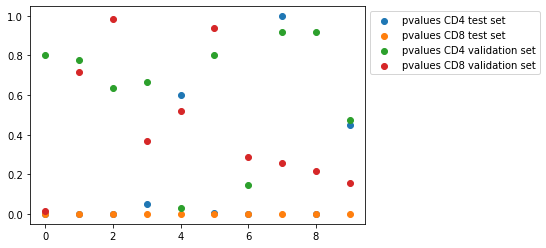

In [29]:
plt.scatter(pval_list_CD4_test.keys(), pval_list_CD4_test.values(),  label = "pvalues CD4 test set")
plt.scatter(pval_list_CD8_test.keys(), pval_list_CD8_test.values(), label = "pvalues CD8 test set")
plt.scatter(pval_list_CD4_val.keys(), pval_list_CD4_val.values(),  label = "pvalues CD4 validation set")
plt.scatter(pval_list_CD8_val.keys(), pval_list_CD8_val.values(),  label = "pvalues CD8 validation set")
plt.plot()
plt.legend( bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
res

In [ ]:
len(pred[pred["Predicted class"] == pred['Majority class']]) / len(pred)

The pvalue is around 0.5 in all cases when I assume that the model is that of the true frequencies.

In [ ]:
 # Choose domains
rng = np.random.default_rng(2)

indices = list(rng.choice(len(other_domains), 5, replace = False))
print(indices)
test_list = [other_domains[i] for i in indices]
training_list = training_list_core + [c for c in other_domains if c not in test_list]

res_1, predictions, results_val = train_and_report_logistic_regression(expression_sc, training_list, "simple", 10)

# This is inside train_and_report_logistic regression and we use it here to obtain the pvalues
# It is deterministic so we can just copy the code
train, test = get_training_and_test_sets(expression_sc, training_list)
    
train_CD4 = train[train["Type"] =="CD4"]
test_CD4 = test[test["Type"] =="CD4"]
train_CD4, validation_CD4 = get_validation_set(train_CD4, 10)

train_CD8 = train[train["Type"] =="CD8"]
test_CD8 = test[test["Type"] =="CD8"]
train_CD8, validation_CD8 = get_validation_set(train_CD8, 10)

In [ ]:
compute_pval(num_iter = 1000, CD_type="CD4",
             prediction_results_df = res_1,
             true_data_df = test_CD4, epsilon = 1e-6)

In [ ]:
compute_pval(num_iter = 500, CD_type="CD8",
             prediction_results_df = res_1,
             true_data_df = test_CD8, epsilon = 1e-6)

In [ ]:
compute_pval(num_iter=1000, CD_type = "CD4", prediction_results_df=results_val, 
            true_data_df=validation_CD4, epsilon=1e-6)

In [ ]:
compute_pval(num_iter=1000, CD_type = "CD8", prediction_results_df=results_val, 
            true_data_df=validation_CD8, epsilon=1e-6)

In [ ]:
res_1

In [ ]:
compute_likelihood("hCD28_h4-1BB", "CD8", res_1, test_CD8, epsilon = 1e-6)

In [ ]:
test_CD4[test_CD4["CAR_Variant"] == "h4-1BB_hCD40"]

In [ ]:
p_effA = np.log(0.360738)
p_cytox = np.log(0.595432)
p_hla = np.log(0.035140)
p_nk = np.log(0.008690)

In [ ]:
# Likelihood of my observed sample
p_effA+ p_cytox+p_effA+p_effA+ p_cytox+p_cytox+p_hla+p_hla

In [ ]:
# Likelihood of a draw
rng = np.random.default_rng(2)
p_vec = [0.360738,0.595432, 0.035140, 0.008690]
pval = 0
for i in range(500):
    ll=0
    draw = np.random.choice(a  = [0,1,2,3], size = 8, p = p_vec)
    for j in range(len(draw)):
        ll+=np.log(p_vec[draw[j]])
    print(ll)
    if ll<-11.311044689580724:
        pval+=1
print(pval/500)

In [ ]:
res_1

In [ ]:
# With a bigger set
observed_ll =compute_likelihood("h4-1BB_hCD40", "CD4", res_1, test_CD4, epsilon = 1e-6)
observed_ll

In [ ]:
# Likelihood of a draw
rng =np.random.default_rng(2)
p_vec = [0.181386,0.459762, 0.000130, 0.358722]
pval = 0
for i in range(500):
    ll=0
    draw = rng.choice(a  = [0,1,2,3], size = 169, p = p_vec)
    for j in range(len(draw)):
        ll+=np.log(p_vec[draw[j]])
    print(ll)
    if ll<-222.10196874722584:
        pval+=1
print(pval/500)

In [ ]:

ident = np.linspace(0,1,100)
# See how well the models learnt the training set
df = expression_sc
freq_CD4 = pd.DataFrame()
for car in sorted(np.unique(train_CD4["CAR_Variant"])):
    for celltype in sorted(np.unique(df["cell_type"]))[0:4]:
        train_CAR_CD4 = train_CD4[train_CD4["CAR_Variant"] == car]
        freq_train_CD4 = len(train_CAR_CD4[train_CAR_CD4["cell_type"]==celltype])/(len(train_CAR_CD4)+0.0001)
        val_CAR_CD4 = validation_CD4[validation_CD4["CAR_Variant"] == car]
        freq_val_CD4 = len(val_CAR_CD4[val_CAR_CD4["cell_type"]==celltype])/(len(val_CAR_CD4)+0.0001)
        freq_CD4 = freq_CD4.append(pd.Series([car, celltype, freq_train_CD4, freq_val_CD4]), ignore_index=True)
freq_CD4.columns = ["CAR", "celltype", "Train freq", "Val freq"]
sns.relplot(data = freq_CD4, x = "Train freq", y = "Val freq")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

freq_CD8= pd.DataFrame()
for car in sorted(np.unique(train_CD8["CAR_Variant"])):
    for celltype in sorted(np.unique(df["cell_type"]))[4:8]:
        train_CAR_CD8 = train_CD8[train_CD8["CAR_Variant"] == car]
        freq_train_CD8 = len(train_CAR_CD8[train_CAR_CD8["cell_type"]==celltype])/(len(train_CAR_CD8)+0.0001)
        val_CAR_CD8 = validation_CD8[validation_CD8["CAR_Variant"] == car]
        freq_val_CD8 = len(val_CAR_CD8[val_CAR_CD8["cell_type"]==celltype])/(len(val_CAR_CD8)+0.0001)
        freq_CD8 = freq_CD8.append(pd.Series([car, celltype, freq_train_CD8, freq_val_CD8]), ignore_index=True)
freq_CD8.columns = ["CAR", "celltype", "Train freq", "Val freq"]


sns.relplot(data = freq_CD8, x = "Train freq", y = "Val freq")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [ ]:
# Then compare predicted proba to training frequencies

freq_CD4.index = freq_CD4[["CAR", "celltype"]]
freq_CD4

In [ ]:
results_val = results_val[results_val["Type"]=="CD4"]
results_val.index = results_val[["CAR Variant", "Cell type"]]
results_val

In [ ]:
df_join = results_val.join(freq_CD4, how = "right")

In [ ]:
ident = np.linspace(0,1,100)
sns.relplot(data = df_join, x= "Train freq", y = "Predicted probability", hue = "celltype")
plt.plot(ident, ident, "--r")
plt.plot(ident, ident-0.1, "--k")
plt.plot(ident, ident+0.1, "--k")

In [ ]:
compute_pval(num_iter = 500, CD_type="CD4",
             prediction_results_df = res_1,
             true_data_df = test_CD4[test_CD4["CAR_Variant"]=="hCD28_h4-1BB"], epsilon = 1e-6)

In [ ]:
validation_CD4

**On a small validation dataset, test that compute_likelihood_test_set works** IT DOES WORK

In [ ]:
test_val = validation_CD4.iloc[[ 45, 139, 127,  91,  17, 197,  29, 171,  75,  44]][["CAR_Variant","cell_type", "Type"]]

In [ ]:
test_val

In [ ]:
ll_observed = (
    np.log(0.395069)+np.log(0.368248)+np.log(0.395097)+np.log(0.424512)+
    np.log(0.477650)+np.log(0.273231)+np.log(0.196858)+np.log(0.414534)+
    np.log(0.420729) + np.log(0.395069)
)
ll_observed

In [ ]:
results_val[results_val["CAR Variant"]=="hCD40_hIL15RA"]

In [ ]:
compute_likelihood_test_set(CD_type="CD4", true_data_df=test_val, predictions_results_df=results_val)

**Manually compute the pvalue on this validation set**

In [ ]:
p_vec_TCR = [0.454935, 0.477650, 0.000957,0.066458 ] # 1 draw
p_vec_41BB = [0.196858, 0.409958,0.000383, 0.392801]# 1 draw
p_vec_41BBCD28 = [0.142857, 0.461875, 0.000199, 0.395069] # 2 draw
p_vec_CD28 = [0.076969, 0.420729, 0.000323,0.501979 ] # 1 draw
p_vec_CD28_IL15RA = [0.104060, 0.424512, 0.009002, 0.462426]# 1 draw
p_vec_CD40_IL15RA = [0.116501, 0.395097, 0.008632,0.479770 ] # 1 draw
p_vec_CDLA4CTLA4 = [0.132620, 0.368248, 0.000325, 0.498807]
p_vec_IL15RACd28 = [0.082300, 0.491214, 0.011952, 0.414534]
p_vec_IL15RAIL155RA = [0.095232,0.273231, 0.395720, 0.235817 ]

vector_list = [p_vec_TCR, p_vec_41BB,p_vec_41BBCD28, p_vec_41BBCD28,
              p_vec_CD28,p_vec_CD28_IL15RA, p_vec_CD40_IL15RA, p_vec_CDLA4CTLA4, 
              p_vec_IL15RACd28,p_vec_IL15RAIL155RA ]

In [ ]:
def compute_drawn_ll(vector_list):
    ll = 0
    for vector in vector_list:
        draw = np.random.choice(p = vector, size = 1, a = [0,1,2,3])[0]
        ll+= np.log(vector[draw])
    print(ll)
    return(ll)

In [ ]:
pval = 0
for i in range(10000):
    ll = compute_drawn_ll(vector_list)
    print(ll)
    if ll<ll_observed:
        pval+=1
pval/10000

In [ ]:
# Compare to pval found using the code
compute_pval(num_iter=10000, true_data_df=test_val, prediction_results_df=results_val, CD_type = "CD4")

**This also seems validated**